### pandas_datareader 的安装

In [35]:
# 安装获取金融数据的库
!pip3 install pandas_datareader matplotlib numpy seaborn --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.1/285.1 kB 1.1 MB/s eta 0:00:00a 0:00:01


In [3]:
# 导入 datareader
import pandas_datareader as web
# 查看版本号
web.__version__

'0.10.0'

### 获取线上股票数据

In [8]:
start_date = '2022-09-01'
end_date = '2022-09-15'

# 设置下载股票代码，数据源名称、开始时间、结束时间
data = web.data.DataReader('601318.ss', 'yahoo', start_date, end_date)

# 查看前 5 行数据
data.head()
# 日期、当日股票最高价、最低价、开盘价、收盘价、成交量、调整后的收盘价

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-09-01,44.130001,43.410000,43.599998,43.650002,45521324,43.650002
2022-09-02,44.279999,43.259998,43.889999,43.700001,44914485,43.700001
2022-09-05,43.900002,43.020000,43.500000,43.799999,41749075,43.799999
2022-09-06,44.450001,43.520000,43.900002,43.900002,44977165,43.900002
2022-09-07,43.810001,43.160000,43.599998,43.599998,37641074,43.599998


### 计算股价变化

In [9]:
# 定义 Diff 字段，记录股价差价 = 当天闭盘价 - 上一天的闭盘价
data['Diff'] = data['Close'].diff()
data.head()

,High,Low,Open,Close,Volume,Adj Close,Diff
Date,,,,,,,
2022-09-01,44.130001,43.410000,43.599998,43.650002,45521324,43.650002,NaN
2022-09-02,44.279999,43.259998,43.889999,43.700001,44914485,43.700001,0.049999
2022-09-05,43.900002,43.020000,43.500000,43.799999,41749075,43.799999,0.099998
2022-09-06,44.450001,43.520000,43.900002,43.900002,44977165,43.900002,0.100002
2022-09-07,43.810001,43.160000,43.599998,43.599998,37641074,43.599998,-0.300003


In [10]:
import numpy as np

# 定义 Signal 字段，标识股票上涨标签
data['Signal'] = np.where(data['Diff'] > 0, 1, 0)
data.head()

,High,Low,Open,Close,Volume,Adj Close,Diff,Signal
Date,,,,,,,,
2022-09-01,44.130001,43.410000,43.599998,43.650002,45521324,43.650002,NaN,0
2022-09-02,44.279999,43.259998,43.889999,43.700001,44914485,43.700001,0.049999,1
2022-09-05,43.900002,43.020000,43.500000,43.799999,41749075,43.799999,0.099998,1
2022-09-06,44.450001,43.520000,43.900002,43.900002,44977165,43.900002,0.100002,1
2022-09-07,43.810001,43.160000,43.599998,43.599998,37641074,43.599998,-0.300003,0


### 交易信号变化可视化

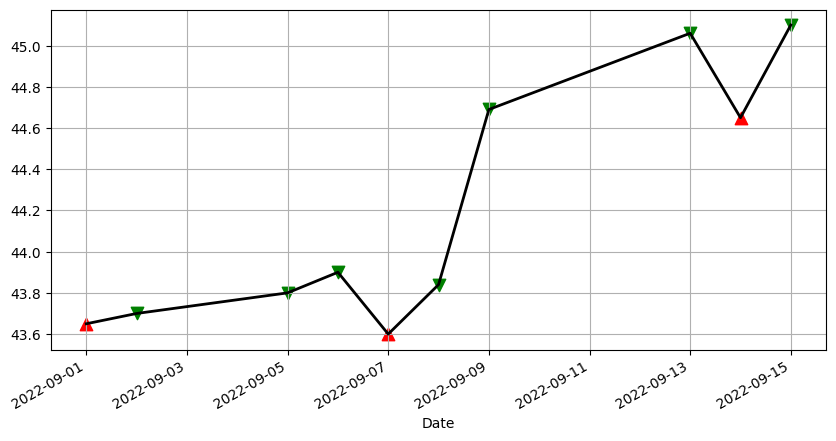

In [33]:
# 导入 matplotlib 画图工具
import matplotlib.pyplot as plt
# 设置画布大小
plt.figure(figsize=(10,5))
# 使用折现图绘制出每天的收盘价
data['Close'].plot(linewidth=2, color='k', grid=True)
# 如果当天上涨，则标记卖出信号，用倒三角表示
plt.scatter(
	data['Close'].loc[data.Signal == 1].index,
  data['Close'][data.Signal == 1],
	marker = 'v',
	s = 80,
	c = 'g'
)
# 如果当天下跌，则标记买入信号，用正三角表示
plt.scatter(
	data['Close'].loc[data.Signal == 0].index,
	data['Close'][data.Signal == 0],
	marker = '^',
	s = 80,
	c = 'r'
)
plt.show()

### 交易侧率 - 回测（backtesting）


In [37]:
# 导入依赖库
from pandas_datareader import data as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 下载线上股票数据
start_date = '2022-06-01'
end_date = '2022-09-15'
zgpa = dt.DataReader('601318.ss', 'yahoo', start_date, end_date)
zgpa.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-06-01,44.549999,43.910000,44.250000,44.169998,32852073.0,42.761215
2022-06-02,44.029999,43.549999,43.799999,44.000000,34082891.0,42.596638
2022-06-06,44.270000,43.330002,43.990002,44.259998,54326745.0,42.848347
2022-06-07,44.380001,43.950001,44.259998,44.150002,43157460.0,42.741856
2022-06-08,44.709999,44.060001,44.250000,44.590000,52956201.0,43.167820


#### 保留原始数据，重新创建一张新表

In [59]:
# 只保留原始数据表中的时间
zgpa_signal = pd.DataFrame(index = zgpa.index)
# 价格以当日调整后闭盘价为准
zgpa_signal['Price'] = zgpa['Adj Close']
# 记录股票涨跌价格
zgpa_signal['Diff'] = zgpa_signal['Price'].diff()
# 对于 NaN 的值使用 0.0 进行补全
zgpa_signal =  zgpa_signal.fillna(0.0)
# 记录股票涨幅标识
zgpa_signal['Signal'] = np.where(zgpa_signal['Diff'] >= 0, 0, 1)
# 根据股票变化进行买入
zgpa_signal['Order'] = zgpa_signal['Signal'].diff() * 100
zgpa_signal.head()

,Price,Diff,Signal,Order
Date,,,,
2022-06-01,42.761215,0.000000,0,NaN
2022-06-02,42.596638,-0.164577,1,100.0
2022-06-06,42.848347,0.251709,0,-100.0
2022-06-07,42.741856,-0.106491,1,100.0
2022-06-08,43.167820,0.425964,0,-100.0


#### 对交易策略进行回测

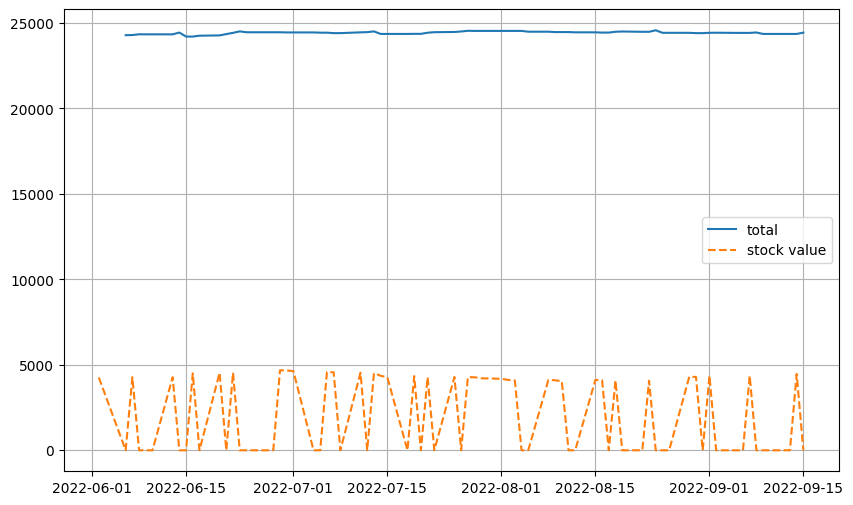

In [66]:
# 初始交易金额
from cProfile import label


initial_cash = 20000.00
# 增加字段，表示交易股票的市值
zgpa_signal['Stock'] = zgpa_signal['Order'] * zgpa_signal['Price']
# 计算剩余的现金
zgpa_signal['Cash'] = initial_cash - ((zgpa_signal['Order'].diff() * zgpa_signal['Price']).cumsum())
# 股市市值 + 剩余的现金
zgpa_signal['Total'] = zgpa_signal['Stock'] + zgpa_signal['Cash']

plt.figure(figsize=(10,6))
plt.plot(zgpa_signal['Total'], label = 'total')
plt.plot(zgpa_signal['Order'].cumsum() * zgpa_signal['Price'], '--' ,label = 'stock value')
plt.grid()
plt.legend(loc='center right')
plt.show()